In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.ml.clustering import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from utilfunctions import *

In [2]:
sqlContext = SQLContext(sc)

In [3]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [4]:
dataDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491035,0,1587256
air_pressure,1587257,916.8301266904981,3.0515931266814733,905.0,929.5
air_temp,1587257,61.85144042835004,11.833623786835787,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970204107,0.0,359.0
avg_wind_speed,1586824,2.7742720679798536,2.0607577935630346,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.36723428064296,0.0,359.0
max_wind_speed,1586824,3.399813400856993,2.423167433617141,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.46274620077628,0.0,359.0
min_wind_speed,1586824,2.1331304542918517,1.7453450849326675,0.0,32.0


In [5]:
dataDF.count()

1587257

In [6]:
#Re-sample to take every 10th value and count new dataset

filtered = dataDF.filter((dataDF.rowID % 10) == 0)
T=filtered.count()
T

158726

In [7]:
# Review the number of zeros in rain_accumulation column
R1 = filtered.filter(filtered.rain_accumulation == 0.0).count() 

# Count the number of zeros in rain_duration column
R2 = filtered.filter(filtered.rain_duration == 0.0).count() 

# We can drop these two columns since most values are ZERO
print "Zeros in rain_accumulation = {} and in rain_duration = {} out of {}".format(R1, R2, T)

Zeros in rain_accumulation = 157812 and in rain_duration = 157237 out of 158726


In [8]:
# Notice that most values of rain_accumulation and rain_duration are 0 so we can drop these columns
# SELECT required columns and drop the rain_* columns

cols = ['rowID',
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

In [9]:
# Select the required columns of interest and count how many rows:
workingDF = filtered.select(cols)
initial = workingDF.count()

In [10]:
# Drop rows with missing values and count how many rows we dropped
workingDF = workingDF.na.drop()
remaining = workingDF.count()
initial - remaining

46

In [11]:
workingDF.take(2)

[Row(rowID=0, air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(rowID=10, air_pressure=912.3, air_temp=62.24, avg_wind_direction=144.0, avg_wind_speed=1.2, max_wind_direction=167.0, max_wind_speed=1.8, relative_humidity=38.5)]

In [12]:
# CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [13]:
# Statistics after conversion of speed to miles per hour
workingDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158680,793627.3355810436,458198.0363632447,0,1587250
air_pressure,158680,916.8304071086608,3.0516872463866034,905.0,929.5
air_temp,158680,61.85578258129617,11.83251581712244,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905898,0.0,359.0
avg_wind_speed,158680,6.20538051172212,4.600847196344543,0.0,71.3284
max_wind_direction,158680,163.46214393748426,92.45213853838689,0.0,359.0
max_wind_speed,158680,7.603647075875902,5.408440424130906,0.22360000000000002,80.49600000000001
relative_humidity,158680,47.59692021678852,26.20783114367006,0.9,93.0


In [14]:
# Features
feat = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

In [15]:
# ASSEMBLE all the features.
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feat, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [16]:
# SCALE the dataset.
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)
# Fit the StandardScaler
scalerModel = scaler.fit(assembled)
# Normalize each feature
scaledData = scalerModel.transform(assembled)

## Compare Statistics of Scaled Data vs Original Data

In [17]:
# UNSCALED : Extract "features_pre" and show first few lines
scaledData.select("features_pre").take(5)

[Row(features_pre=DenseVector([912.3, 64.76, 97.0, 2.6832, 106.0, 3.5776, 60.5])),
 Row(features_pre=DenseVector([912.3, 62.24, 144.0, 2.6832, 167.0, 4.0248, 38.5])),
 Row(features_pre=DenseVector([912.2, 63.32, 100.0, 4.472, 122.0, 5.59, 58.3])),
 Row(features_pre=DenseVector([912.2, 62.6, 91.0, 4.472, 103.0, 5.3664, 57.9])),
 Row(features_pre=DenseVector([912.2, 64.04, 81.0, 5.8136, 88.0, 6.4844, 57.4]))]

In [18]:
# SCALED : Extract "features" and show first few lines
scaledData.select("features").take(5)

[Row(features=DenseVector([-1.4846, 0.2454, -0.6839, -0.7656, -0.6215, -0.7444, 0.4923])),
 Row(features=DenseVector([-1.4846, 0.0325, -0.1906, -0.7656, 0.0383, -0.6617, -0.3471])),
 Row(features=DenseVector([-1.5173, 0.1237, -0.6524, -0.3768, -0.4485, -0.3723, 0.4084])),
 Row(features=DenseVector([-1.5173, 0.0629, -0.7468, -0.3768, -0.654, -0.4137, 0.3931])),
 Row(features=DenseVector([-1.5173, 0.1846, -0.8518, -0.0852, -0.8162, -0.2069, 0.3741]))]

In [19]:
# Keep features and leave other columns
scaledData = scaledData.select("features", "rowID")

In [26]:
#ELBOW method
from utilfunctions import *

wssseList = []

#Sample a small subset for ELBOW technique
elbowset   = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

elbow(elbowset, wssseList)

Training for k = 2 
......................WSSSE = 114993.131812 
Training for k = 3 
......................WSSSE = 104181.097858 
Training for k = 4 
......................WSSSE = 94577.2715129 
Training for k = 5 
......................WSSSE = 87993.4609842 
Training for k = 6 
......................WSSSE = 85084.239223 
Training for k = 7 
......................WSSSE = 81664.9602449 
Training for k = 8 
......................WSSSE = 78397.7674511 
Training for k = 9 
......................WSSSE = 76599.6081578 
Training for k = 10 
......................WSSSE = 74023.939305 
Training for k = 11 
......................WSSSE = 72772.6105604 
Training for k = 12 
......................WSSSE = 70281.8172391 
Training for k = 13 
......................WSSSE = 69473.5324363 
Training for k = 14 
......................WSSSE = 68756.1232916 
Training for k = 15 
......................WSSSE = 67394.285242 
Training for k = 16 
......................WSSSE = 66698.4474492 
Training for k = 17 


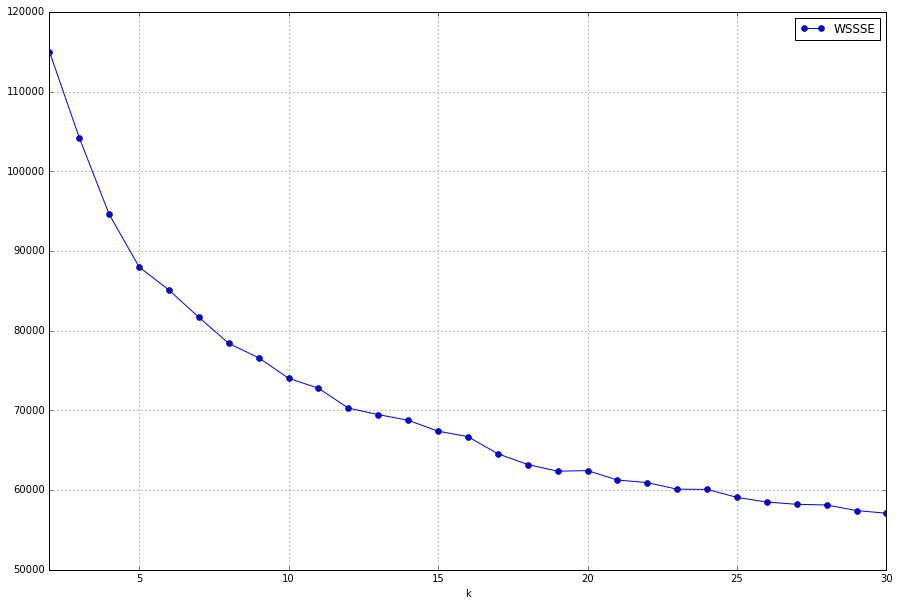

In [27]:
wssseDF = pd.DataFrame({'WSSSE' : wssseList, 'k' : range(2,31) })
wssseDF.plot(y='WSSSE', x='k', figsize=(15,10), grid=True, marker='o')

# Clustering using selected k

In [29]:
# Re-Sampled dataset: Review the graph above and run k-means for a specific k on "scaledData":

scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

kmeans			= KMeans(k=11, seed = 1)
model			= kmeans.fit(scaledDataFeat)
transformed		= model.transform(scaledDataFeat)
featuresAndPrediction	= transformed.select("features", "prediction")
errorWSSSE		= computeCost(featuresAndPrediction, model)
print(errorWSSSE)

220283.795543


In [30]:
#How many members per clusters
import pyspark.sql.functions as func
featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|            30936|
|         1|             7953|
|         2|            14855|
|         3|            11484|
|         4|            16227|
|         5|            20155|
|         6|            20172|
|         7|             6652|
|         8|             5498|
|         9|            11083|
|        10|            13665|
+----------+-----------------+



In [31]:
from pandas.tools.plotting import parallel_coordinates
import numpy as np

In [32]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [33]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)
P['prediction'] = P['prediction'].astype(int)

In [34]:
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.043428,0.905866,0.642539,-0.494142,0.835637,-0.488251,-0.670313,0
1,1.189026,-0.253277,-1.155012,2.090282,-1.052935,2.206960,-1.132840,1
2,-0.565094,-1.292509,0.416177,0.427880,0.517754,0.413462,1.412005,2
3,0.735529,-0.777575,1.004843,-0.552814,1.240439,-0.519485,0.587207,3
4,-0.682463,-0.398536,0.186502,-0.615707,0.354628,-0.619010,0.779680,4
5,-0.203712,0.841905,-1.267714,-0.605291,-1.118569,-0.620635,-0.607982,5
6,-0.459034,0.309244,0.418717,1.050488,0.514257,0.986362,0.006080,6
7,0.246610,0.308076,1.887917,-0.652587,-1.549914,-0.577226,-0.273534,7
8,-1.530533,-1.302854,0.386447,2.169100,0.494487,2.129375,1.381498,8
9,0.144485,-0.824306,-1.226355,-0.548973,-1.078678,-0.564186,0.878956,9


## Plots

## Dry Days

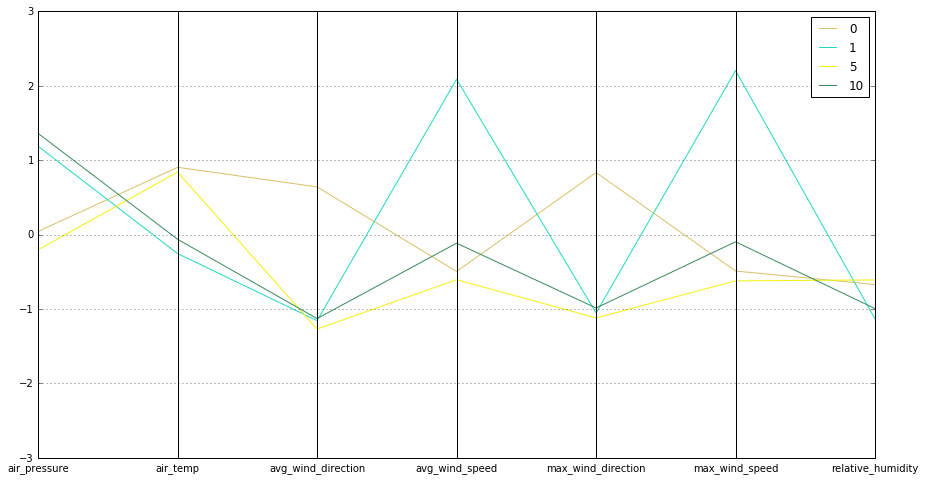

In [35]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['relative_humidity']< -0.5], 'prediction')

## Warm Days

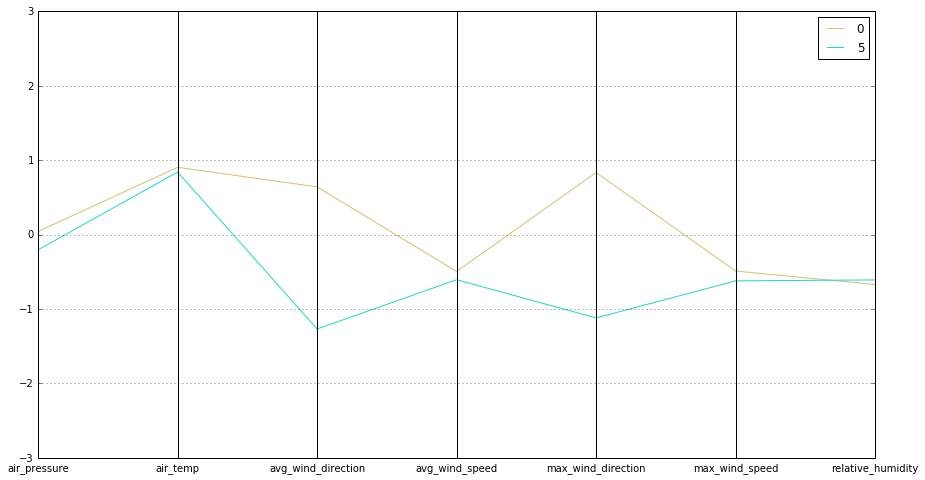

In [36]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['air_temp']> 0.5], 'prediction')

## Cool Days

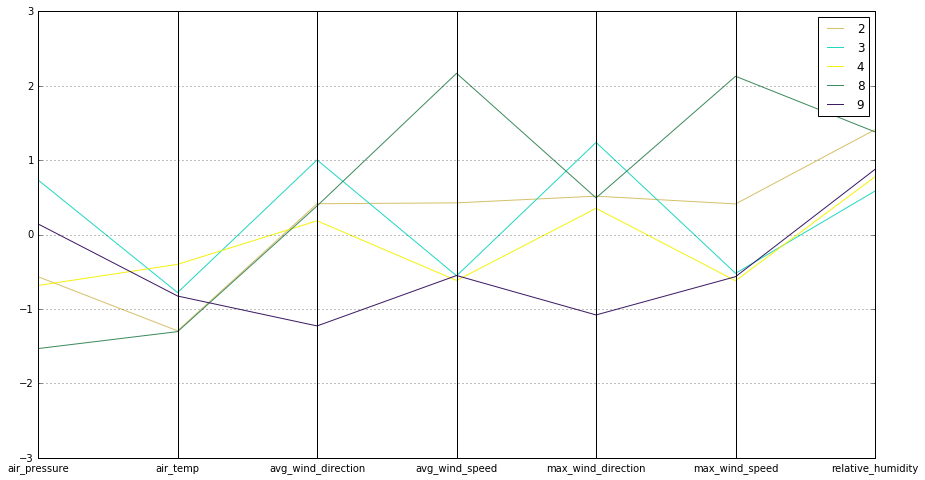

In [37]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[(P['relative_humidity']>0.5) & (P['air_temp']< 0.5)], 'prediction')

## Other Days

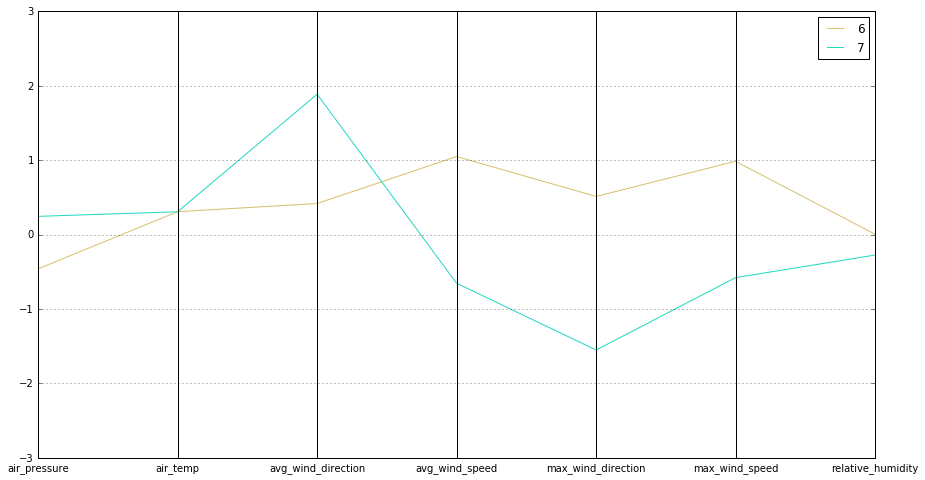

In [38]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])

parallel_coordinates(P.iloc[[6,7]], 'prediction')